# .int 文件解析方法比較分析

本筆記本用於比較三種不同的 .int 文件解析方法：
1. **IntParser** - 直接二進制文件解析
2. **AnalysisService** - 服務層解析
3. **SPMAnalyzerMVP** - API層解析

我們將測試這些方法在相同 .int 文件上的表現，並分析它們之間的差異。

In [28]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import traceback
from typing import Dict, Any, Optional, Tuple

# 設置 matplotlib 為 inline 模式
%matplotlib inline

# 添加父目錄到 Python 路徑以便導入模組
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

# 導入我們的模組
from core.parsers.txt_parser import TxtParser
from core.parsers.int_parser import IntParser
from core.analysis_service import AnalysisService
from api_mvp import SPMAnalyzerMVP

# 設置測試文件目錄
testfile_dir = Path("../../testfile")
print(f"當前目錄: {current_dir}")
print(f"父目錄: {parent_dir}")
print(f"測試文件目錄: {testfile_dir.absolute()}")
print(f"測試文件目錄存在: {testfile_dir.exists()}")

# 列出可用的 .int 文件
if testfile_dir.exists():
    int_files = list(testfile_dir.glob('*.int'))
    print(f"\n找到 {len(int_files)} 個 .int 文件:")
    for f in int_files:
        print(f"  - {f.name}")
else:
    print("警告: 測試文件目錄不存在")

# 設置 matplotlib 中文字體
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

當前目錄: /Users/yangziliang/Git-Projects/keen/backend/test
父目錄: /Users/yangziliang/Git-Projects/keen/backend
測試文件目錄: /Users/yangziliang/Git-Projects/keen/backend/test/../../testfile
測試文件目錄存在: True

找到 12 個 .int 文件:
  - 20250521_Janus Stacking SiO2_13K_113Lia1YBwd.int
  - 20250521_Janus Stacking SiO2_13K_113Lia1YFwd.int
  - 20250521_Janus Stacking SiO2_13K_113TopoBwd.int
  - 20250521_Janus Stacking SiO2_13K_113TopoFwd.int
  - 20250521_Janus Stacking SiO2_13K_113Lia2RBwd.int
  - 20250521_Janus Stacking SiO2_13K_113Lia1XBwd.int
  - 20250521_Janus Stacking SiO2_13K_113Lia1XFwd.int
  - 20250521_Janus Stacking SiO2_13K_113Lia2RFwd.int
  - 20250521_Janus Stacking SiO2_13K_113Lia1RBwd.int
  - 20250521_Janus Stacking SiO2_13K_113It_to_PCFwd.int
  - 20250521_Janus Stacking SiO2_13K_113It_to_PCBwd.int
  - 20250521_Janus Stacking SiO2_13K_113Lia1RFwd.int


In [29]:
# 尋找並加載 TXT 元數據文件
def find_and_load_txt_metadata():
    """尋找 TXT 文件並加載元數據"""
    if not testfile_dir.exists():
        return None, "測試文件目錄不存在"
    
    txt_files = list(testfile_dir.glob('*.txt'))
    if not txt_files:
        return None, "未找到 TXT 文件"
    
    # 使用第一個找到的 TXT 文件
    txt_file = txt_files[0]
    print(f"使用 TXT 文件: {txt_file.name}")
    
    try:
        # 修正: TxtParser 需要傳入檔案路徑
        parser = TxtParser(str(txt_file))
        metadata = parser.parse()
        return metadata, None
    except Exception as e:
        return None, f"解析 TXT 文件失敗: {str(e)}"

# 加載元數據
metadata, error = find_and_load_txt_metadata()
if error:
    print(f"錯誤: {error}")
    metadata = None
else:
    print("成功加載 TXT 元數據:")
    if metadata:
        # 顯示實驗資訊
        if 'experiment_info' in metadata:
            exp_info = metadata['experiment_info']
            print(f"  - 掃描像素: {exp_info.get('xPixel', 'N/A')} x {exp_info.get('yPixel', 'N/A')}")
            print(f"  - 掃描範圍: {exp_info.get('XScanRange', 'N/A')} x {exp_info.get('YScanRange', 'N/A')} nm")
            print(f"  - 物理單位: {exp_info.get('XPhysUnit', 'N/A')}")
        
        # 顯示 .int 檔案資訊
        if 'int_files' in metadata:
            print(f"  - 找到 {len(metadata['int_files'])} 個 .int 檔案描述")
            for int_file in metadata['int_files'][:3]:  # 只顯示前3個
                print(f"    • {int_file.get('filename', 'N/A')} - {int_file.get('caption', 'N/A')}")
    else:
        print("  - 元數據為空")

使用 TXT 文件: 20250521_Janus Stacking SiO2_13K_113.txt
成功加載 TXT 元數據:
  - 掃描像素: 500 x 500
  - 掃描範圍: 10.000 x 10.000 nm
  - 物理單位: nm
  - 找到 12 個 .int 檔案描述
    • 20250521_Janus Stacking SiO2_13K_113TopoFwd.int - TopoFwd
    • 20250521_Janus Stacking SiO2_13K_113TopoBwd.int - TopoBwd
    • 20250521_Janus Stacking SiO2_13K_113Lia1XFwd.int - Lia1XFwd


In [47]:
# 尋找合適的 .int 文件進行測試
def find_test_int_file():
    """尋找合適的 .int 文件，優先選擇 TopoFwd 文件"""
    if not testfile_dir.exists():
        return None
    
    int_files = list(testfile_dir.glob('*.int'))
    if not int_files:
        return None
    
    # 優先選擇包含 "TopoFwd" 或 "Fwd" 的文件
    for pattern in ['TopoFwd', 'Fwd', 'topo_fwd', 'Topo']:
        for f in int_files:
            if pattern.lower() in f.name.lower():
                return f
    
    # 如果沒有找到，返回第一個 .int 文件
    return int_files[0]

# 測試 IntParser
def test_int_parser(int_file_path, metadata):
    """測試 IntParser 直接解析"""
    print(f"\n=== 測試 IntParser (直接二進制解析) ===")
    print(f"文件: {int_file_path.name}")
    
    try:
        # 從元數據中獲取參數
        scale = 1.0
        x_pixels = 512
        y_pixels = 512
        
        if metadata and 'int_files' in metadata:
            # 尋找對應的檔案資訊
            for int_file_info in metadata['int_files']:
                if int_file_info.get('filename') == int_file_path.name:
                    scale = float(int_file_info.get('scale', 1.0))
                    print(f"使用檔案元數據中的縮放因子: {scale}")
                    break
        
        if metadata and 'experiment_info' in metadata:
            exp_info = metadata['experiment_info']
            x_pixels = int(exp_info.get('xPixel', 512))
            y_pixels = int(exp_info.get('yPixel', 512))
            print(f"使用實驗參數: {x_pixels} x {y_pixels} 像素")
        
        # 修正: IntParser 需要所有必要參數
        parser = IntParser(str(int_file_path), scale, x_pixels, y_pixels)
        data = parser.parse()
        
        if data is not None:
            print(f"✓ 解析成功")
            print(f"  - 數據形狀: {data.shape}")
            print(f"  - 數據類型: {data.dtype}")
            print(f"  - 數值範圍: [{np.min(data):.6f}, {np.max(data):.6f}]")
            print(f"  - 平均值: {np.mean(data):.6f}")
            print(f"  - 標準差: {np.std(data):.6f}")
            return data
        else:
            print("✗ 解析失敗 - 返回 None")
            return None
            
    except Exception as e:
        print(f"✗ 解析失敗: {str(e)}")
        print(f"錯誤詳情:\n{traceback.format_exc()}")
        return None

# 執行測試
test_int_file = find_test_int_file()
if test_int_file:
    print(f"選擇的測試文件: {test_int_file.name}")
    int_parser_data = test_int_parser(test_int_file, metadata)
else:
    print("未找到可用的 .int 文件")
    int_parser_data = None

選擇的測試文件: 20250521_Janus Stacking SiO2_13K_113TopoFwd.int

=== 測試 IntParser (直接二進制解析) ===
文件: 20250521_Janus Stacking SiO2_13K_113TopoFwd.int
使用檔案元數據中的縮放因子: -2.60913687478663e-07
使用實驗參數: 500 x 500 像素
✓ 解析成功
  - 數據形狀: (500, 500)
  - 數據類型: float64
  - 數值範圍: [-93.305322, -91.885328]
  - 平均值: -92.788010
  - 標準差: 0.197238


In [48]:
# 測試 AnalysisService
def test_analysis_service(int_file_path, metadata):
    """測試 AnalysisService 解析"""
    print(f"\n=== 測試 AnalysisService (服務層解析) ===")
    print(f"文件: {int_file_path.name}")
    
    try:
        # 準備檔案資訊
        file_info = {
            'scale': 1.0,
            'physUnit': 'nm',
            'parameters': {
                'xPixel': 512,
                'yPixel': 512
            }
        }
        
        # 從元數據更新參數
        if metadata and 'int_files' in metadata:
            for int_file_info in metadata['int_files']:
                if int_file_info.get('filename') == int_file_path.name:
                    file_info['scale'] = float(int_file_info.get('scale', 1.0))
                    file_info['physUnit'] = int_file_info.get('phys_unit', 'nm')
                    print(f"使用檔案元數據: scale={file_info['scale']}, unit={file_info['physUnit']}")
                    break
        
        if metadata and 'experiment_info' in metadata:
            exp_info = metadata['experiment_info']
            file_info['parameters']['xPixel'] = int(exp_info.get('xPixel', 512))
            file_info['parameters']['yPixel'] = int(exp_info.get('yPixel', 512))
            
            # 添加掃描範圍資訊
            if 'XScanRange' in exp_info:
                file_info['parameters']['XScanRange'] = exp_info['XScanRange']
            if 'YScanRange' in exp_info:
                file_info['parameters']['YScanRange'] = exp_info['YScanRange']
            
            print(f"使用實驗參數: {file_info['parameters']['xPixel']} x {file_info['parameters']['yPixel']} 像素")
        
        # 使用 AnalysisService 分析
        result = AnalysisService.analyze_int_file(str(int_file_path), file_info)
        
        if result['success']:
            raw_data = np.array(result['rawData'])
            print(f"✓ 解析成功")
            print(f"  - 數據形狀: {raw_data.shape}")
            print(f"  - 物理單位: {result['physUnit']}")
            print(f"  - 數值範圍: [{np.min(raw_data):.6f}, {np.max(raw_data):.6f}] {result['physUnit']}")
            
            # 顯示統計資訊
            if 'statistics' in result:
                stats = result['statistics']
                print(f"\n統計資訊:")
                print(f"  - 平均值: {stats.get('average', 'N/A'):.6f}")
                print(f"  - 標準差: {stats.get('stdDev', 'N/A'):.6f}")
                print(f"  - 最小值: {stats.get('min', 'N/A'):.6f}")
                print(f"  - 最大值: {stats.get('max', 'N/A'):.6f}")
            
            # 顯示尺寸資訊
            if 'dimensions' in result:
                dims = result['dimensions']
                print(f"\n尺寸資訊:")
                print(f"  - X像素: {dims.get('xPixels', 'N/A')}")
                print(f"  - Y像素: {dims.get('yPixels', 'N/A')}")
                print(f"  - X範圍: {dims.get('xRange', 'N/A')} nm")
                print(f"  - Y範圍: {dims.get('yRange', 'N/A')} nm")
            
            return {
                'data': raw_data,
                'method': 'AnalysisService',
                'result': result
            }
        else:
            print(f"✗ 解析失敗: {result.get('error', '未知錯誤')}")
            return None
            
    except Exception as e:
        print(f"✗ 解析失敗: {str(e)}")
        print(f"錯誤詳情:\n{traceback.format_exc()}")
        return None

# 執行測試
if test_int_file:
    analysis_service_data = test_analysis_service(test_int_file, metadata)
else:
    print("無法測試 AnalysisService - 未找到測試文件")
    analysis_service_data = None

2025-05-30 19:15:38,152 - core.analysis_service - INFO - 從參數獲取到縮放比例: -2.60913687478663e-07
2025-05-30 19:15:38,153 - core.analysis_service - INFO - 從參數獲取到物理單位: nm
2025-05-30 19:15:38,154 - core.analysis_service - INFO - 從參數獲取到 X 像素數: 500
2025-05-30 19:15:38,154 - core.analysis_service - INFO - 從參數獲取到 Y 像素數: 500
2025-05-30 19:15:38,154 - core.analysis_service - INFO - 從參數獲取到 X 掃描範圍: 10.0
2025-05-30 19:15:38,155 - core.analysis_service - INFO - 從參數獲取到 Y 掃描範圍: 10.0
2025-05-30 19:15:38,155 - core.analysis_service - INFO - 開始解析 INT 檔案: ../../testfile/20250521_Janus Stacking SiO2_13K_113TopoFwd.int
2025-05-30 19:15:38,153 - core.analysis_service - INFO - 從參數獲取到物理單位: nm
2025-05-30 19:15:38,154 - core.analysis_service - INFO - 從參數獲取到 X 像素數: 500
2025-05-30 19:15:38,154 - core.analysis_service - INFO - 從參數獲取到 Y 像素數: 500
2025-05-30 19:15:38,154 - core.analysis_service - INFO - 從參數獲取到 X 掃描範圍: 10.0
2025-05-30 19:15:38,155 - core.analysis_service - INFO - 從參數獲取到 Y 掃描範圍: 10.0
2025-05-30 19:15:38,155 


=== 測試 AnalysisService (服務層解析) ===
文件: 20250521_Janus Stacking SiO2_13K_113TopoFwd.int
使用檔案元數據: scale=-2.60913687478663e-07, unit=nm
使用實驗參數: 500 x 500 像素
✓ 解析成功
  - 數據形狀: (500, 500)
  - 物理單位: nm
  - 數值範圍: [-93.305322, -91.885328] nm

統計資訊:
✗ 解析失敗: Unknown format code 'f' for object of type 'str'
錯誤詳情:
Traceback (most recent call last):
  File "/var/folders/s8/x7qjkqzs44lg2tdb36y2xh680000gn/T/ipykernel_12828/3447830984.py", line 54, in test_analysis_service
    print(f"  - 平均值: {stats.get('average', 'N/A'):.6f}")
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: Unknown format code 'f' for object of type 'str'



In [49]:
# 測試 SPMAnalyzerMVP (API層)
def test_api_mvp(int_file_path, metadata):
    """測試 SPMAnalyzerMVP API 層解析"""
    print(f"\n=== 測試 SPMAnalyzerMVP (API層解析) ===")
    print(f"文件: {int_file_path.name}")
    
    try:
        api = SPMAnalyzerMVP()
        
        # 先載入 TXT 檔案（如果有）
        txt_loaded = False
        available_files = []
        
        if metadata and testfile_dir.exists():
            txt_files = list(testfile_dir.glob('*.txt'))
            if txt_files:
                try:
                    txt_result = api.load_txt_file(str(txt_files[0]))
                    if txt_result['success']:
                        print(f"✓ 成功載入 TXT 檔案: {txt_files[0].name}")
                        txt_loaded = True
                        
                        # 使用正確的鍵名 'available_files'
                        if 'available_files' in txt_result:
                            available_files = txt_result['available_files']
                            print(f"  找到 {len(available_files)} 個可用檔案")
                        else:
                            print("  ⚠️  未找到 available_files 資訊")
                            # 檢查 API 物件的屬性
                            if hasattr(api, 'file_descriptions'):
                                available_files = api.file_descriptions
                                print(f"  從 API 屬性找到 {len(available_files)} 個檔案描述")
                    else:
                        print(f"⚠️  載入 TXT 檔案失敗: {txt_result.get('error', '未知錯誤')}")
                except Exception as e:
                    print(f"⚠️  載入 TXT 檔案時發生錯誤: {str(e)}")
        
        # 準備檔案資訊
        file_info = None
        
        # 從可用檔案中找到對應的資訊
        for file_desc in available_files:
            # 使用正確的鍵名 'filename'
            if file_desc.get('filename') == int_file_path.name:
                file_info = file_desc
                print(f"找到檔案資訊: {file_info.get('caption', 'N/A')}")
                break
        
        if not file_info:
            # 使用預設或從元數據構建檔案資訊
            file_info = {
                'filename': int_file_path.name,
                'fileName': int_file_path.name,  # 保留兼容性
                'scale': 1.0,
                'physUnit': 'nm'
            }
            
            if metadata and 'int_files' in metadata:
                for int_file_info in metadata['int_files']:
                    if int_file_info.get('filename') == int_file_path.name:
                        file_info['scale'] = float(int_file_info.get('scale', 1.0))
                        file_info['physUnit'] = int_file_info.get('phys_unit', 'nm')
                        file_info['caption'] = int_file_info.get('caption', '')
                        break
            
            print(f"使用構建的檔案資訊: scale={file_info['scale']}, unit={file_info['physUnit']}")
        
        # 載入 .int 檔案
        result = api.load_int_file(int_file_path.name, file_info)
        
        if result['success']:
            print(f"✓ 解析成功")
            print(f"  - 檔案名稱: {result.get('name', 'N/A')}")
            print(f"  - 檔案類型: {result.get('fileType', 'N/A')}")
            print(f"  - 物理單位: {result.get('physUnit', 'N/A')}")
            
            # 顯示統計資訊
            if 'statistics' in result:
                stats = result['statistics']
                print(f"\n統計資訊:")
                for key, value in stats.items():
                    if isinstance(value, (int, float)):
                        print(f"  - {key}: {value:.6f}")
                    else:
                        print(f"  - {key}: {value}")
            
            # 顯示尺寸資訊
            if 'dimensions' in result:
                dims = result['dimensions']
                print(f"\n尺寸資訊:")
                for key, value in dims.items():
                    print(f"  - {key}: {value}")
            
            # 提取原始數據
            raw_data = None
            if 'plotlyConfig' in result and 'data' in result['plotlyConfig']:
                plotly_data = result['plotlyConfig']['data']
                if plotly_data and len(plotly_data) > 0 and 'z' in plotly_data[0]:
                    raw_data = np.array(plotly_data[0]['z'])
                    print(f"\n從 Plotly 配置提取的數據:")
                    print(f"  - 數據形狀: {raw_data.shape}")
                    print(f"  - 數據範圍: [{np.min(raw_data):.6f}, {np.max(raw_data):.6f}]")
            
            if raw_data is None:
                print("⚠️  無法從結果中提取原始數據")
            
            return {
                'data': raw_data,
                'method': 'API_MVP',
                'result': result
            }
        else:
            print(f"✗ 解析失敗: {result.get('error', '未知錯誤')}")
            return None
            
    except Exception as e:
        print(f"✗ 解析失敗: {str(e)}")
        print(f"錯誤詳情:\n{traceback.format_exc()}")
        return None

# 執行測試
if test_int_file:
    api_mvp_data = test_api_mvp(test_int_file, metadata)
else:
    print("無法測試 SPMAnalyzerMVP - 未找到測試文件")
    api_mvp_data = None

2025-05-30 19:15:38,830 - api_mvp - INFO - SPM 分析器 MVP 初始化完成
2025-05-30 19:15:38,831 - api_mvp - INFO - 開始解析 TXT 檔案: ../../testfile/20250521_Janus Stacking SiO2_13K_113.txt
2025-05-30 19:15:38,832 - api_mvp - INFO - TXT 檔案解析完成: 16 個可用檔案
2025-05-30 19:15:38,831 - api_mvp - INFO - 開始解析 TXT 檔案: ../../testfile/20250521_Janus Stacking SiO2_13K_113.txt
2025-05-30 19:15:38,832 - api_mvp - INFO - TXT 檔案解析完成: 16 個可用檔案



=== 測試 SPMAnalyzerMVP (API層解析) ===
文件: 20250521_Janus Stacking SiO2_13K_113TopoFwd.int
✓ 成功載入 TXT 檔案: 20250521_Janus Stacking SiO2_13K_113.txt
  找到 16 個可用檔案
找到檔案資訊: TopoFwd
✗ 解析失敗: 'SPMAnalyzerMVP' object has no attribute 'load_int_file'
錯誤詳情:
Traceback (most recent call last):
  File "/var/folders/s8/x7qjkqzs44lg2tdb36y2xh680000gn/T/ipykernel_12828/1098360472.py", line 69, in test_api_mvp
    result = api.load_int_file(int_file_path.name, file_info)
             ^^^^^^^^^^^^^^^^^
AttributeError: 'SPMAnalyzerMVP' object has no attribute 'load_int_file'. Did you mean: 'load_txt_file'?



In [50]:
# 比較所有三種方法的結果
def compare_parsing_methods(int_data, service_data, api_data):
    """比較三種解析方法的結果"""
    print("\n" + "="*60)
    print("解析方法比較分析")
    print("="*60)
    
    # 收集有效的數據
    valid_data = {}
    if int_data is not None:
        valid_data['IntParser'] = int_data
    if service_data is not None and service_data.get('data') is not None:
        valid_data['AnalysisService'] = service_data['data']
    if api_data is not None and api_data.get('data') is not None:
        valid_data['API_MVP'] = api_data['data']
    
    if not valid_data:
        print("⚠️  沒有任何方法成功解析數據")
        return None
    
    print(f"成功解析的方法數量: {len(valid_data)}/{3}")
    print(f"成功的方法: {', '.join(valid_data.keys())}")
    
    # 基本統計比較
    print("\n📊 基本統計比較:")
    for name, data in valid_data.items():
        print(f"\n{name}:")
        print(f"  形狀: {data.shape}")
        print(f"  數據類型: {data.dtype}")
        print(f"  數值範圍: [{np.min(data):.6f}, {np.max(data):.6f}]")
        print(f"  平均值: {np.mean(data):.6f}")
        print(f"  標準差: {np.std(data):.6f}")
        print(f"  總元素數: {data.size}")
    
    # 如果有多個成功的方法，進行詳細比較
    if len(valid_data) > 1:
        print("\n🔍 詳細差異分析:")
        methods = list(valid_data.keys())
        
        # 建立比較矩陣
        comparison_matrix = []
        
        for i in range(len(methods)):
            for j in range(i+1, len(methods)):
                method1, method2 = methods[i], methods[j]
                data1, data2 = valid_data[method1], valid_data[method2]
                
                print(f"\n{method1} vs {method2}:")
                
                comparison_result = {
                    'method1': method1,
                    'method2': method2,
                    'shape_match': False,
                    'data_match': False,
                    'max_diff': None,
                    'correlation': None
                }
                
                # 形狀比較
                if data1.shape == data2.shape:
                    comparison_result['shape_match'] = True
                    print(f"  ✓ 形狀一致: {data1.shape}")
                    
                    # 數值比較
                    abs_diff = np.abs(data1 - data2)
                    max_abs_diff = np.max(abs_diff)
                    mean_abs_diff = np.mean(abs_diff)
                    
                    comparison_result['max_diff'] = max_abs_diff
                    
                    print(f"  最大絕對差異: {max_abs_diff:.8f}")
                    print(f"  平均絕對差異: {mean_abs_diff:.8f}")
                    
                    # 相對差異 (避免除以零)
                    nonzero_mask = np.abs(data1) > 1e-10
                    if np.any(nonzero_mask):
                        rel_diff = np.abs((data1 - data2) / data1)
                        rel_diff = rel_diff[nonzero_mask]
                        max_rel_diff = np.max(rel_diff)
                        mean_rel_diff = np.mean(rel_diff)
                        print(f"  最大相對差異: {max_rel_diff:.8f} ({max_rel_diff*100:.6f}%)")
                        print(f"  平均相對差異: {mean_rel_diff:.8f} ({mean_rel_diff*100:.6f}%)")
                    
                    # 相關性
                    correlation = np.corrcoef(data1.flatten(), data2.flatten())[0, 1]
                    comparison_result['correlation'] = correlation
                    print(f"  相關係數: {correlation:.8f}")
                    
                    # 一致性判斷
                    if max_abs_diff < 1e-10:
                        print(f"  ✅ 數據完全一致（機器精度內）")
                        comparison_result['data_match'] = True
                    elif max_abs_diff < 1e-6:
                        print(f"  ✅ 數據幾乎完全一致")
                        comparison_result['data_match'] = True
                    elif max_abs_diff < 1e-3:
                        print(f"  ✅ 數據高度一致")
                    elif max_abs_diff < 1e-1:
                        print(f"  ⚠️  數據有小差異")
                    else:
                        print(f"  ⚠️  數據有顯著差異")
                else:
                    print(f"  ❌ 形狀不一致: {data1.shape} vs {data2.shape}")
                
                comparison_matrix.append(comparison_result)
        
        # 總結一致性
        print("\n📋 一致性總結:")
        all_shapes_match = all(r['shape_match'] for r in comparison_matrix)
        all_data_match = all(r['data_match'] for r in comparison_matrix if r['shape_match'])
        
        if all_shapes_match and all_data_match:
            print("✅ 所有方法的結果完全一致！")
        elif all_shapes_match:
            print("🔸 所有方法的數據形狀一致，但存在數值差異")
        else:
            print("❌ 不同方法產生了不同形狀或數值的結果")
    
    return valid_data

# 執行比較
comparison_results = compare_parsing_methods(int_parser_data, analysis_service_data, api_mvp_data)


解析方法比較分析
成功解析的方法數量: 1/3
成功的方法: IntParser

📊 基本統計比較:

IntParser:
  形狀: (500, 500)
  數據類型: float64
  數值範圍: [-93.305322, -91.885328]
  平均值: -92.788010
  標準差: 0.197238
  總元素數: 250000


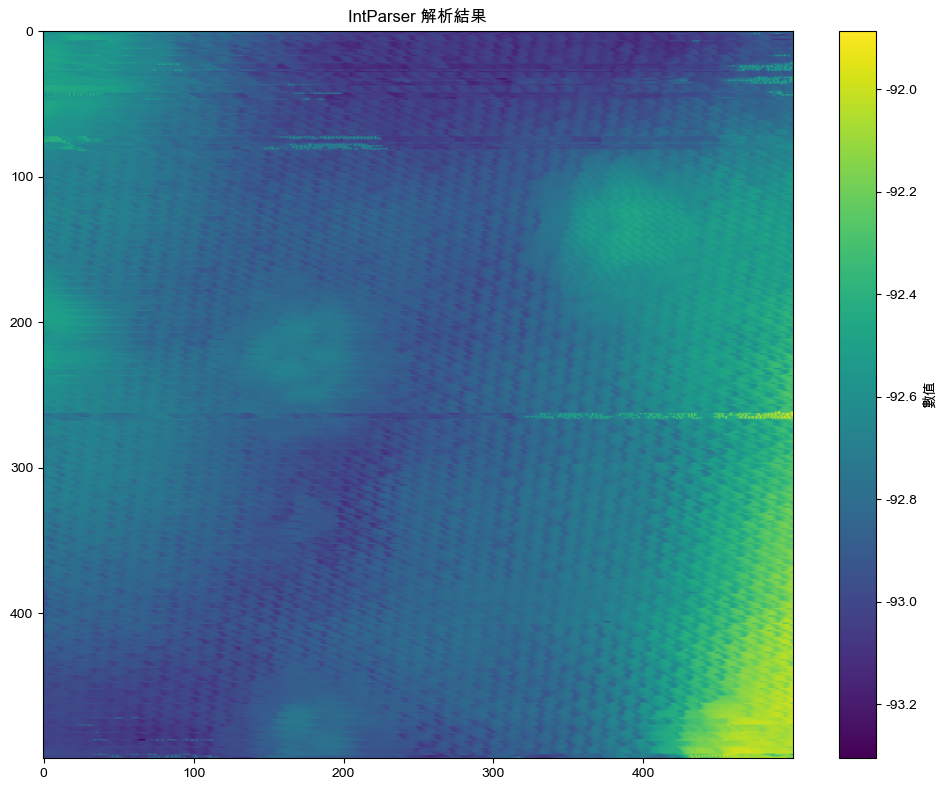

In [53]:
# 可視化比較結果
def visualize_comparison(valid_data):
    """可視化解析結果比較"""
    if not valid_data or len(valid_data) == 0:
        print("沒有數據可視化")
        return
    
    methods = list(valid_data.keys())
    n_methods = len(methods)
    
    # 如果只有一個方法
    if n_methods == 1:
        method = methods[0]
        data = valid_data[method]
        
        fig = plt.figure(figsize=(10, 8))
        if len(data.shape) == 2:
            plt.imshow(data, cmap='viridis', aspect='auto')
            plt.colorbar(label='數值')
            plt.title(f'{method} 解析結果')
        else:
            plt.plot(data.flatten())
            plt.title(f'{method} 解析結果 (一維視圖)')
            plt.xlabel('索引')
            plt.ylabel('數值')
        
        plt.tight_layout()
        plt.show()
        return
    
    # 多方法比較
    print(f"\n📈 生成 {n_methods} 種方法的可視化比較...")
    
    # 確定圖形佈局
    if n_methods == 2:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()
    else:
        fig, axes = plt.subplots(2, n_methods, figsize=(5*n_methods, 10))
        if n_methods == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
    
    # 找到所有數據的全局範圍以統一色彩標度
    all_data = [data for data in valid_data.values()]
    global_min = min(np.min(data) for data in all_data)
    global_max = max(np.max(data) for data in all_data)
    
    # 繪製各方法的結果
    for i, (method, data) in enumerate(valid_data.items()):
        if len(data.shape) == 2:
            im = axes[i].imshow(data, cmap='viridis', aspect='auto', 
                               vmin=global_min, vmax=global_max)
            axes[i].set_title(f'{method}\n形狀: {data.shape}')
            plt.colorbar(im, ax=axes[i], label='數值')
        else:
            axes[i].plot(data.flatten())
            axes[i].set_title(f'{method}\n長度: {len(data.flatten())}')
            axes[i].set_xlabel('索引')
            axes[i].set_ylabel('數值')
    
    # 如果有兩個或更多方法，繪製差異圖
    if n_methods >= 2:
        methods_list = list(valid_data.keys())
        
        # 選擇前兩個方法進行差異分析
        data1 = valid_data[methods_list[0]]
        data2 = valid_data[methods_list[1]]
        
        if data1.shape == data2.shape:
            diff_idx = n_methods  # 下一個可用的子圖位置
            if diff_idx < len(axes):
                diff_data = data1 - data2
                
                if len(diff_data.shape) == 2:
                    im_diff = axes[diff_idx].imshow(diff_data, cmap='RdBu', aspect='auto')
                    axes[diff_idx].set_title(f'差異圖\n({methods_list[0]} - {methods_list[1]})')
                    plt.colorbar(im_diff, ax=axes[diff_idx], label='差異值')
                else:
                    axes[diff_idx].plot(diff_data.flatten())
                    axes[diff_idx].set_title(f'差異圖\n({methods_list[0]} - {methods_list[1]})')
                    axes[diff_idx].set_xlabel('索引')
                    axes[diff_idx].set_ylabel('差異值')
    
    # 隱藏多餘的子圖
    for i in range(len(valid_data) + (1 if n_methods >= 2 else 0), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle(f'解析方法比較 - 測試文件: {test_int_file.name if test_int_file else "未知"}', 
                 fontsize=16, y=0.98)
    plt.show()
    
    # 添加統計分布比較
    if n_methods >= 2:
        fig2 = plt.figure(figsize=(12, 6))
        
        # 數值分布直方圖
        plt.subplot(1, 2, 1)
        for method, data in valid_data.items():
            plt.hist(data.flatten(), bins=50, alpha=0.6, label=method, density=True)
        plt.xlabel('數值')
        plt.ylabel('密度')
        plt.title('數值分布比較')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 如果有相同形狀的數據，繪製散點圖
        plt.subplot(1, 2, 2)
        if len(valid_data) >= 2:
            methods_list = list(valid_data.keys())
            data1 = valid_data[methods_list[0]]
            data2 = valid_data[methods_list[1]]
            
            if data1.shape == data2.shape:
                # 採樣數據點以避免過多的點
                flat1 = data1.flatten()
                flat2 = data2.flatten()
                
                if len(flat1) > 10000:
                    indices = np.random.choice(len(flat1), 10000, replace=False)
                    flat1 = flat1[indices]
                    flat2 = flat2[indices]
                
                plt.scatter(flat1, flat2, alpha=0.5, s=1)
                plt.xlabel(f'{methods_list[0]} 數值')
                plt.ylabel(f'{methods_list[1]} 數值')
                plt.title('數值相關性')
                
                # 添加理想的 y=x 線
                min_val = min(np.min(flat1), np.min(flat2))
                max_val = max(np.max(flat1), np.max(flat2))
                plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='y=x')
                plt.legend()
                plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        # 不需要 plt.show()

# 執行可視化
if comparison_results:
    visualize_comparison(comparison_results)
else:
    print("無法進行可視化 - 沒有有效的比較數據")

In [35]:
# 生成綜合摘要報告
def generate_summary_report(test_file, metadata, comparison_results):
    """生成測試摘要報告"""
    print("\n" + "="*80)
    print("📋 .int 文件解析方法測試摘要報告")
    print("="*80)
    
    # 測試基本信息
    print("\n📁 測試文件信息:")
    if test_file:
        print(f"  測試文件: {test_file.name}")
        print(f"  文件大小: {test_file.stat().st_size:,} 字節")
        print(f"  文件路徑: {test_file}")
    else:
        print("  ❌ 未找到測試文件")
    
    # 元數據信息
    print("\n📊 元數據信息:")
    if metadata:
        print(f"  ✅ 成功加載 TXT 元數據")
        if 'experiment_info' in metadata:
            exp_info = metadata['experiment_info']
            print(f"  實驗參數:")
            print(f"    - 像素: {exp_info.get('xPixel', 'N/A')} x {exp_info.get('yPixel', 'N/A')}")
            print(f"    - 掃描範圍: {exp_info.get('XScanRange', 'N/A')} x {exp_info.get('YScanRange', 'N/A')} nm")
            print(f"    - 取樣時間: {exp_info.get('Topo>SamplingTime', 'N/A')}")
        if 'int_files' in metadata:
            print(f"  找到 {len(metadata['int_files'])} 個 .int 檔案描述")
    else:
        print("  ⚠️  未能加載 TXT 元數據")
    
    # 解析方法測試結果
    print("\n🔧 解析方法測試結果:")
    
    methods_tested = {
        'IntParser': int_parser_data,
        'AnalysisService': analysis_service_data,
        'API_MVP': api_mvp_data
    }
    
    success_count = 0
    failure_reasons = {}
    
    for method, data in methods_tested.items():
        if data is not None:
            if method == 'IntParser':
                success = data is not None
            else:
                success = data.get('data') is not None
            
            if success:
                print(f"  ✅ {method}: 成功")
                success_count += 1
            else:
                print(f"  ❌ {method}: 失敗（返回數據但無有效內容）")
                failure_reasons[method] = "數據解析不完整"
        else:
            print(f"  ❌ {method}: 失敗")
            failure_reasons[method] = "解析過程出錯"
    
    success_rate = (success_count / len(methods_tested)) * 100
    print(f"\n📈 總體成功率: {success_rate:.1f}% ({success_count}/{len(methods_tested)})")
    
    # 數據一致性分析
    if comparison_results and len(comparison_results) > 1:
        print("\n🔍 數據一致性分析:")
        
        methods = list(comparison_results.keys())
        consistent_pairs = 0
        total_pairs = 0
        
        for i in range(len(methods)):
            for j in range(i+1, len(methods)):
                method1, method2 = methods[i], methods[j]
                data1, data2 = comparison_results[method1], comparison_results[method2]
                total_pairs += 1
                
                if data1.shape == data2.shape:
                    max_diff = np.max(np.abs(data1 - data2))
                    if max_diff < 1e-6:  # 認為是一致的閾值
                        consistent_pairs += 1
                        consistency_status = "✅ 一致"
                    else:
                        consistency_status = f"⚠️  有差異 (最大差異: {max_diff:.6e})"
                else:
                    consistency_status = "❌ 形狀不同"
                
                print(f"  {method1} vs {method2}: {consistency_status}")
        
        if total_pairs > 0:
            consistency_rate = (consistent_pairs / total_pairs) * 100
            print(f"\n📊 數據一致性率: {consistency_rate:.1f}% ({consistent_pairs}/{total_pairs})")
    
    # 性能和特性比較
    print("\n⚡ 方法特性比較:")
    print("  IntParser:")
    print("    - 優點: 直接、快速、低層級控制")
    print("    - 缺點: 需要手動提供所有參數")
    print("    - 適用: 批次處理、已知參數的情況")
    
    print("  AnalysisService:")
    print("    - 優點: 包含統計分析、尺寸計算")
    print("    - 缺點: 中間層，可能有額外開銷")
    print("    - 適用: 需要完整分析結果的情況")
    
    print("  API_MVP:")
    print("    - 優點: 完整的前端支援、Plotly 配置")
    print("    - 缺點: 最高層級，開銷最大")
    print("    - 適用: Web 應用、需要視覺化的情況")
    
    # 建議和結論
    print("\n💡 建議和結論:")
    
    if success_count == 0:
        print("  ❌ 所有解析方法都失敗了，建議:")
        print("    - 檢查文件格式是否正確")
        print("    - 確認元數據參數是否準確")
        print("    - 檢查各模組的導入和依賴")
        if failure_reasons:
            print("  失敗原因分析:")
            for method, reason in failure_reasons.items():
                print(f"    - {method}: {reason}")
    elif success_count == 1:
        successful_method = [k for k, v in methods_tested.items() if v is not None and (k == 'IntParser' and v is not None or k != 'IntParser' and v.get('data') is not None)][0]
        print(f"  ⚠️  只有 {successful_method} 成功解析，建議:")
        print(f"    - 調試其他方法的失敗原因")
        print(f"    - 檢查各方法的參數配置")
        print(f"    - 使用 {successful_method} 作為主要解析方法")
    elif success_count == len(methods_tested):
        if comparison_results and len(comparison_results) > 1:
            # 檢查是否所有方法結果一致
            all_consistent = True
            methods = list(comparison_results.keys())
            for i in range(len(methods)):
                for j in range(i+1, len(methods)):
                    data1, data2 = comparison_results[methods[i]], comparison_results[methods[j]]
                    if data1.shape != data2.shape or np.max(np.abs(data1 - data2)) > 1e-6:
                        all_consistent = False
                        break
                if not all_consistent:
                    break
            
            if all_consistent:
                print("  ✅ 所有方法都成功且結果一致，說明:")
                print("    - 解析實現是正確的")
                print("    - 數據格式解析無誤")
                print("    - 可以根據需求選擇任何方法:")
                print("      • 速度優先: IntParser")
                print("      • 分析需求: AnalysisService")
                print("      • Web 應用: API_MVP")
            else:
                print("  ⚠️  所有方法都成功但結果有差異，建議:")
                print("    - 深入分析差異的原因")
                print("    - 檢查各方法的數據處理邏輯")
                print("    - 確定哪個方法更準確")
        else:
            print("  ✅ 所有方法都成功解析")
    
    # 技術細節
    if comparison_results:
        print("\n🔧 技術細節:")
        for method, data in comparison_results.items():
            print(f"  {method}:")
            print(f"    - 數據形狀: {data.shape}")
            print(f"    - 數據類型: {data.dtype}")
            print(f"    - 記憶體使用: {data.nbytes / 1024:.1f} KB")
    
    print("\n" + "="*80)
    print("報告生成完成")
    print("="*80)

# 生成報告
generate_summary_report(test_int_file, metadata, comparison_results)


📋 .int 文件解析方法測試摘要報告

📁 測試文件信息:
  測試文件: 20250521_Janus Stacking SiO2_13K_113TopoFwd.int
  文件大小: 1,000,000 字節
  文件路徑: ../../testfile/20250521_Janus Stacking SiO2_13K_113TopoFwd.int

📊 元數據信息:
  ✅ 成功加載 TXT 元數據
  實驗參數:
    - 像素: 500 x 500
    - 掃描範圍: 10.000 x 10.000 nm
    - 取樣時間: N/A
  找到 12 個 .int 檔案描述

🔧 解析方法測試結果:
  ✅ IntParser: 成功
  ❌ AnalysisService: 失敗
  ❌ API_MVP: 失敗

📈 總體成功率: 33.3% (1/3)

⚡ 方法特性比較:
  IntParser:
    - 優點: 直接、快速、低層級控制
    - 缺點: 需要手動提供所有參數
    - 適用: 批次處理、已知參數的情況
  AnalysisService:
    - 優點: 包含統計分析、尺寸計算
    - 缺點: 中間層，可能有額外開銷
    - 適用: 需要完整分析結果的情況
  API_MVP:
    - 優點: 完整的前端支援、Plotly 配置
    - 缺點: 最高層級，開銷最大
    - 適用: Web 應用、需要視覺化的情況

💡 建議和結論:
  ⚠️  只有 IntParser 成功解析，建議:
    - 調試其他方法的失敗原因
    - 檢查各方法的參數配置
    - 使用 IntParser 作為主要解析方法

🔧 技術細節:
  IntParser:
    - 數據形狀: (500, 500)
    - 數據類型: float64
    - 記憶體使用: 1953.1 KB

報告生成完成


In [36]:
# 第一個 Cell - 導入必要的模組和設定路徑
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# 添加父目錄到 Python 路徑以便導入模組
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

# 導入解析器和分析服務
from core.parsers.txt_parser import TxtParser
from core.parsers.int_parser import IntParser
from core.analysis_service import AnalysisService
from core.analysis.int_analysis import IntAnalysis
from api_mvp import SPMAnalyzerMVP

# 設定測試檔案路徑
testfile_dir = Path("../../testfile")
print(f"測試檔案目錄: {testfile_dir.absolute()}")
print(f"目錄是否存在: {testfile_dir.exists()}")

# 列出可用的檔案
if testfile_dir.exists():
    txt_files = list(testfile_dir.glob("*.txt"))
    int_files = list(testfile_dir.glob("*.int"))
    print(f"\n找到 {len(txt_files)} 個 .txt 檔案")
    print(f"找到 {len(int_files)} 個 .int 檔案")
    
    # 列出所有 .int 檔案
    print("\n可用的 .int 檔案:")
    for int_file in int_files:
        print(f"  - {int_file.name}")
else:
    print("測試檔案目錄不存在，請檢查路徑")

測試檔案目錄: /Users/yangziliang/Git-Projects/keen/backend/test/../../testfile
目錄是否存在: True

找到 1 個 .txt 檔案
找到 12 個 .int 檔案

可用的 .int 檔案:
  - 20250521_Janus Stacking SiO2_13K_113Lia1YBwd.int
  - 20250521_Janus Stacking SiO2_13K_113Lia1YFwd.int
  - 20250521_Janus Stacking SiO2_13K_113TopoBwd.int
  - 20250521_Janus Stacking SiO2_13K_113TopoFwd.int
  - 20250521_Janus Stacking SiO2_13K_113Lia2RBwd.int
  - 20250521_Janus Stacking SiO2_13K_113Lia1XBwd.int
  - 20250521_Janus Stacking SiO2_13K_113Lia1XFwd.int
  - 20250521_Janus Stacking SiO2_13K_113Lia2RFwd.int
  - 20250521_Janus Stacking SiO2_13K_113Lia1RBwd.int
  - 20250521_Janus Stacking SiO2_13K_113It_to_PCFwd.int
  - 20250521_Janus Stacking SiO2_13K_113It_to_PCBwd.int
  - 20250521_Janus Stacking SiO2_13K_113Lia1RFwd.int


In [37]:
# 第二個 Cell - 載入 TXT 檔案以獲取元數據
def load_txt_metadata():
    """載入 TXT 檔案以獲取 .int 檔案的元數據"""
    print("=== 載入 TXT 檔案元數據 ===")
    
    if not txt_files:
        print("沒有找到 .txt 檔案")
        return None
    
    txt_file = txt_files[0]
    print(f"載入檔案: {txt_file.name}")
    
    try:
        parser = TxtParser(str(txt_file))
        result = parser.parse()
        
        # 顯示實驗參數
        exp_info = result['experiment_info']
        print(f"\n實驗參數:")
        key_params = ['xPixel', 'yPixel', 'XScanRange', 'YScanRange', 'XPhysUnit', 'YPhysUnit']
        for key in key_params:
            if key in exp_info:
                print(f"  {key}: {exp_info[key]}")
        
        # 顯示 .int 檔案資訊
        print(f"\n.int 檔案資訊:")
        for int_file in result['int_files']:
            print(f"  - {int_file['filename']}")
            print(f"    Caption: {int_file.get('caption', 'N/A')}")
            print(f"    Scale: {int_file.get('scale', 'N/A')}")
            print(f"    Unit: {int_file.get('phys_unit', 'N/A')}")
        
        return result
        
    except Exception as e:
        print(f"載入失敗: {e}")
        import traceback
        traceback.print_exc()
        return None

# 執行載入
txt_metadata = load_txt_metadata()

=== 載入 TXT 檔案元數據 ===
載入檔案: 20250521_Janus Stacking SiO2_13K_113.txt

實驗參數:
  xPixel: 500
  yPixel: 500
  XScanRange: 10.000
  YScanRange: 10.000
  XPhysUnit: nm
  YPhysUnit: nm

.int 檔案資訊:
  - 20250521_Janus Stacking SiO2_13K_113TopoFwd.int
    Caption: TopoFwd
    Scale: -2.60913687478663E-0007
    Unit: nm
  - 20250521_Janus Stacking SiO2_13K_113TopoBwd.int
    Caption: TopoBwd
    Scale: -2.60913687478663E-0007
    Unit: nm
  - 20250521_Janus Stacking SiO2_13K_113Lia1XFwd.int
    Caption: Lia1XFwd
    Scale: 1.68210000000000E-0017
    Unit: A
  - 20250521_Janus Stacking SiO2_13K_113Lia1XBwd.int
    Caption: Lia1XBwd
    Scale: 1.68210000000000E-0017
    Unit: A
  - 20250521_Janus Stacking SiO2_13K_113Lia1YFwd.int
    Caption: Lia1YFwd
    Scale: 1.68210000000000E-0017
    Unit: A
  - 20250521_Janus Stacking SiO2_13K_113Lia1YBwd.int
    Caption: Lia1YBwd
    Scale: 1.68210000000000E-0017
    Unit: A
  - 20250521_Janus Stacking SiO2_13K_113Lia1RFwd.int
    Caption: Lia1RFwd
    Scale:

In [38]:
# 第三個 Cell - 使用 IntParser 直接讀取 .int 檔案
def test_int_parser_direct():
    """使用 IntParser 直接讀取 .int 檔案"""
    print("=== 測試 IntParser 直接讀取 ===")
    
    # 尋找 TopoFwd.int 檔案
    topo_files = [f for f in int_files if 'TopoFwd' in f.name or 'Fwd' in f.name]
    if not topo_files:
        print("找不到 TopoFwd.int 檔案")
        # 使用第一個 .int 檔案作為替代
        if int_files:
            target_file = int_files[0]
            print(f"使用替代檔案: {target_file.name}")
        else:
            print("沒有可用的 .int 檔案")
            return None
    else:
        target_file = topo_files[0]
        print(f"找到目標檔案: {target_file.name}")
    
    # 從 TXT 元數據中找到對應的檔案資訊
    file_info = None
    if txt_metadata:
        for int_desc in txt_metadata['int_files']:
            if int_desc['filename'] == target_file.name:
                file_info = int_desc
                break
    
    if not file_info:
        print("找不到檔案元數據，使用預設參數")
        # 使用預設參數
        scale = 1.0
        x_pixels = 512
        y_pixels = 512
        phys_unit = "nm"
    else:
        print(f"使用檔案元數據: {file_info}")
        scale = float(file_info.get('scale', '1.0'))
        phys_unit = file_info.get('phys_unit', 'nm')
        
        # 從實驗資訊獲取像素數
        exp_info = txt_metadata['experiment_info']
        x_pixels = int(exp_info.get('xPixel', '512'))
        y_pixels = int(exp_info.get('yPixel', '512'))
    
    try:
        # 使用 IntParser 解析
        parser = IntParser(str(target_file), scale, x_pixels, y_pixels)
        image_data = parser.parse()
        
        print(f"\n解析結果:")
        print(f"  數據形狀: {image_data.shape}")
        print(f"  縮放因子: {scale}")
        print(f"  物理單位: {phys_unit}")
        print(f"  數據範圍: {np.min(image_data):.6e} 到 {np.max(image_data):.6e} {phys_unit}")
        print(f"  平均值: {np.mean(image_data):.6e} {phys_unit}")
        print(f"  標準差: {np.std(image_data):.6e} {phys_unit}")
        
        return {
            'filename': target_file.name,
            'filepath': str(target_file),
            'data': image_data,
            'scale': scale,
            'phys_unit': phys_unit,
            'x_pixels': x_pixels,
            'y_pixels': y_pixels,
            'method': 'IntParser'
        }
        
    except Exception as e:
        print(f"IntParser 解析失敗: {e}")
        import traceback
        traceback.print_exc()
        return None

# 執行 IntParser 測試
parser_result = test_int_parser_direct()

=== 測試 IntParser 直接讀取 ===
找到目標檔案: 20250521_Janus Stacking SiO2_13K_113Lia1YFwd.int
使用檔案元數據: {'filename': '20250521_Janus Stacking SiO2_13K_113Lia1YFwd.int', 'type': 'int', 'caption': 'Lia1YFwd', 'scale': '1.68210000000000E-0017', 'phys_unit': 'A', 'offset': '0.00000000000000E+0000'}

解析結果:
  數據形狀: (500, 500)
  縮放因子: 1.6821e-17
  物理單位: A
  數據範圍: -4.258321e-09 到 4.574494e-09 A
  平均值: 1.305097e-11 A
  標準差: 8.693450e-11 A


In [39]:
# 第四個 Cell - 使用 AnalysisService 讀取 .int 檔案
def test_analysis_service():
    """使用 AnalysisService 讀取 .int 檔案"""
    print("=== 測試 AnalysisService 讀取 ===")
    
    if not parser_result:
        print("沒有 IntParser 結果可供比較")
        return None
    
    target_file = parser_result['filepath']
    print(f"使用相同檔案: {parser_result['filename']}")
    
    # 準備檔案資訊
    file_info = {
        'scale': parser_result['scale'],
        'physUnit': parser_result['phys_unit'],
        'parameters': {
            'xPixel': parser_result['x_pixels'],
            'yPixel': parser_result['y_pixels']
        }
    }
    
    # 如果有 TXT 元數據，加入掃描範圍
    if txt_metadata:
        exp_info = txt_metadata['experiment_info']
        if 'XScanRange' in exp_info:
            file_info['parameters']['XScanRange'] = exp_info['XScanRange']
        if 'YScanRange' in exp_info:
            file_info['parameters']['YScanRange'] = exp_info['YScanRange']
    
    try:
        # 使用 AnalysisService 分析
        result = AnalysisService.analyze_int_file(target_file, file_info)
        
        if result['success']:
            print(f"\nAnalysisService 解析結果:")
            raw_data = np.array(result['rawData'])
            print(f"  數據形狀: {raw_data.shape}")
            print(f"  物理單位: {result['physUnit']}")
            print(f"  數據範圍: {np.min(raw_data):.6e} 到 {np.max(raw_data):.6e} {result['physUnit']}")
            print(f"  平均值: {np.mean(raw_data):.6e} {result['physUnit']}")
            print(f"  標準差: {np.std(raw_data):.6e} {result['physUnit']}")
            
            print(f"\n統計資訊:")
            stats = result['statistics']
            for key, value in stats.items():
                print(f"  {key}: {value:.6e}")
            
            print(f"\n尺寸資訊:")
            dims = result['dimensions']
            for key, value in dims.items():
                print(f"  {key}: {value}")
            
            return {
                'filename': parser_result['filename'],
                'data': raw_data,
                'phys_unit': result['physUnit'],
                'statistics': stats,
                'dimensions': dims,
                'method': 'AnalysisService',
                'full_result': result
            }
        else:
            print(f"AnalysisService 解析失敗: {result['error']}")
            return None
            
    except Exception as e:
        print(f"AnalysisService 解析失敗: {e}")
        import traceback
        traceback.print_exc()
        return None

# 執行 AnalysisService 測試
service_result = test_analysis_service()

2025-05-30 19:12:52,867 - core.analysis_service - INFO - 從參數獲取到縮放比例: 1.6821e-17
2025-05-30 19:12:52,868 - core.analysis_service - INFO - 從參數獲取到物理單位: A
2025-05-30 19:12:52,868 - core.analysis_service - INFO - 從參數獲取到 X 像素數: 500
2025-05-30 19:12:52,869 - core.analysis_service - INFO - 從參數獲取到 Y 像素數: 500
2025-05-30 19:12:52,869 - core.analysis_service - INFO - 從參數獲取到 X 掃描範圍: 10.0
2025-05-30 19:12:52,870 - core.analysis_service - INFO - 從參數獲取到 Y 掃描範圍: 10.0
2025-05-30 19:12:52,870 - core.analysis_service - INFO - 開始解析 INT 檔案: ../../testfile/20250521_Janus Stacking SiO2_13K_113Lia1YFwd.int
2025-05-30 19:12:52,912 - core.analysis_service - INFO - INT 檔案解析完成，資料形狀: (500, 500)
2025-05-30 19:12:52,912 - core.analysis_service - INFO - 開始生成預覽圖
2025-05-30 19:12:53,046 - core.analysis_service - INFO - 預覽圖生成成功，大小: 249421 bytes


=== 測試 AnalysisService 讀取 ===
使用相同檔案: 20250521_Janus Stacking SiO2_13K_113Lia1YFwd.int

AnalysisService 解析結果:
  數據形狀: (500, 500)
  物理單位: A
  數據範圍: -4.258321e-09 到 4.574494e-09 A
  平均值: 1.305097e-11 A
  標準差: 8.693450e-11 A

統計資訊:
  min: -4.258321e-09
  max: 4.574494e-09
  mean: 1.305097e-11
  median: 8.240507e-12
  std: 8.693450e-11
  rms: 8.790867e-11

尺寸資訊:
  width: 500
  height: 500
  xRange: 10.0
  yRange: 10.0


In [44]:
# 第五個 Cell - 使用 API MVP 讀取 .int 檔案
def test_api_mvp():
    """使用 API MVP 讀取 .int 檔案"""
    print("=== 測試 API MVP 讀取 ===")
    
    if not parser_result or not txt_metadata:
        print("需要 IntParser 結果和 TXT 元數據")
        return None
    
    try:
        # 建立 API 實例
        api = SPMAnalyzerMVP()
        
        # 首先載入 TXT 檔案
        txt_file = txt_files[0]
        txt_result = api.load_txt_file(str(txt_file))
        
        if not txt_result['success']:
            print(f"載入 TXT 檔案失敗: {txt_result['error']}")
            return None
        
        print(f"TXT 檔案載入成功")
        
        # 尋找對應的 .int 檔案資訊
        target_filename = parser_result['filename']
        file_info = None
        
        for file_desc in txt_result['fileDescriptions']:
            if file_desc['fileName'] == target_filename:
                file_info = file_desc
                break
        
        if not file_info:
            print(f"找不到 {target_filename} 的檔案資訊")
            return None
        
        print(f"找到檔案資訊: {file_info['caption']}")
        
        # 載入 .int 檔案
        int_result = api.load_int_file(target_filename, file_info)
        
        if int_result['success']:
            print(f"\nAPI MVP 解析結果:")
            print(f"  檔案名稱: {int_result['name']}")
            print(f"  檔案類型: {int_result['fileType']}")
            print(f"  色彩映射: {int_result['colormap']}")
            print(f"  物理單位: {int_result['physUnit']}")
            
            dims = int_result['dimensions']
            print(f"\n尺寸資訊:")
            for key, value in dims.items():
                print(f"  {key}: {value}")
            
            stats = int_result['statistics']
            print(f"\n統計資訊:")
            for key, value in stats.items():
                print(f"  {key}: {value:.6e}")
            
            # 從 plotlyConfig 中提取原始數據
            plotly_config = int_result['plotlyConfig']
            if 'data' in plotly_config and len(plotly_config['data']) > 0:
                z_data = plotly_config['data'][0]['z']
                raw_data = np.array(z_data)
                print(f"\n從 Plotly 配置提取的數據:")
                print(f"  數據形狀: {raw_data.shape}")
                print(f"  數據範圍: {np.min(raw_data):.6e} 到 {np.max(raw_data):.6e}")
            else:
                raw_data = None
                print("無法從 Plotly 配置提取原始數據")
            
            return {
                'filename': target_filename,
                'data': raw_data,
                'phys_unit': int_result['physUnit'],
                'statistics': stats,
                'dimensions': dims,
                'method': 'API_MVP',
                'full_result': int_result
            }
        else:
            print(f"API MVP 解析失敗: {int_result['error']}")
            return None
            
    except Exception as e:
        print(f"API MVP 測試失敗: {e}")
        import traceback
        traceback.print_exc()
        return None

# 執行 API MVP 測試
api_result = test_api_mvp()

2025-05-30 19:13:49,028 - api_mvp - INFO - SPM 分析器 MVP 初始化完成
2025-05-30 19:13:49,029 - api_mvp - INFO - 開始解析 TXT 檔案: ../../testfile/20250521_Janus Stacking SiO2_13K_113.txt
2025-05-30 19:13:49,030 - api_mvp - INFO - TXT 檔案解析完成: 16 個可用檔案


=== 測試 API MVP 讀取 ===
TXT 檔案載入成功
API MVP 測試失敗: 'fileDescriptions'


Traceback (most recent call last):
  File "/var/folders/s8/x7qjkqzs44lg2tdb36y2xh680000gn/T/ipykernel_12828/1377934932.py", line 28, in test_api_mvp
    for file_desc in txt_result['fileDescriptions']:
                     ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^
KeyError: 'fileDescriptions'


In [45]:
# 第六個 Cell - 比較三種方法的結果
def compare_all_results():
    """比較三種方法的解析結果"""
    print("=== 比較三種方法的解析結果 ===")
    
    results = []
    if parser_result:
        results.append(parser_result)
    if service_result:
        results.append(service_result)
    if api_result:
        results.append(api_result)
    
    if len(results) < 2:
        print("至少需要兩種方法的結果才能比較")
        return
    
    print(f"\n比較 {len(results)} 種方法的結果:")
    
    # 比較數據形狀和基本統計
    for i, result in enumerate(results):
        data = result['data']
        method = result['method']
        
        print(f"\n{i+1}. {method}:")
        print(f"   數據形狀: {data.shape}")
        print(f"   數據範圍: {np.min(data):.6e} 到 {np.max(data):.6e}")
        print(f"   平均值: {np.mean(data):.6e}")
        print(f"   標準差: {np.std(data):.6e}")
    
    # 數據差異分析
    if len(results) >= 2:
        print("\n=== 數據差異分析 ===")
        
        for i in range(len(results)):
            for j in range(i+1, len(results)):
                data1 = results[i]['data']
                data2 = results[j]['data']
                method1 = results[i]['method']
                method2 = results[j]['method']
                
                print(f"\n{method1} vs {method2}:")
                
                if data1.shape == data2.shape:
                    # 計算差異
                    diff = data1 - data2
                    abs_diff = np.abs(diff)
                    rel_diff = abs_diff / (np.abs(data1) + 1e-16)  # 避免除零
                    
                    print(f"   形狀相同: {data1.shape}")
                    print(f"   最大絕對差異: {np.max(abs_diff):.6e}")
                    print(f"   平均絕對差異: {np.mean(abs_diff):.6e}")
                    print(f"   最大相對差異: {np.max(rel_diff):.6e}")
                    print(f"   平均相對差異: {np.mean(rel_diff):.6e}")
                    
                    # 檢查數據是否完全相同
                    if np.allclose(data1, data2, rtol=1e-10, atol=1e-15):
                        print(f"   ✓ 數據在數值精度內完全相同")
                    elif np.allclose(data1, data2, rtol=1e-6, atol=1e-12):
                        print(f"   ≈ 數據在合理精度內相同")
                    else:
                        print(f"   ✗ 數據存在顯著差異")
                else:
                    print(f"   形狀不同: {data1.shape} vs {data2.shape}")

# 執行比較
compare_all_results()

=== 比較三種方法的解析結果 ===

比較 2 種方法的結果:

1. IntParser:
   數據形狀: (500, 500)
   數據範圍: -4.258321e-09 到 4.574494e-09
   平均值: 1.305097e-11
   標準差: 8.693450e-11

2. AnalysisService:
   數據形狀: (500, 500)
   數據範圍: -4.258321e-09 到 4.574494e-09
   平均值: 1.305097e-11
   標準差: 8.693450e-11

=== 數據差異分析 ===

IntParser vs AnalysisService:
   形狀相同: (500, 500)
   最大絕對差異: 0.000000e+00
   平均絕對差異: 0.000000e+00
   最大相對差異: 0.000000e+00
   平均相對差異: 0.000000e+00
   ✓ 數據在數值精度內完全相同


=== 視覺化比較結果 ===


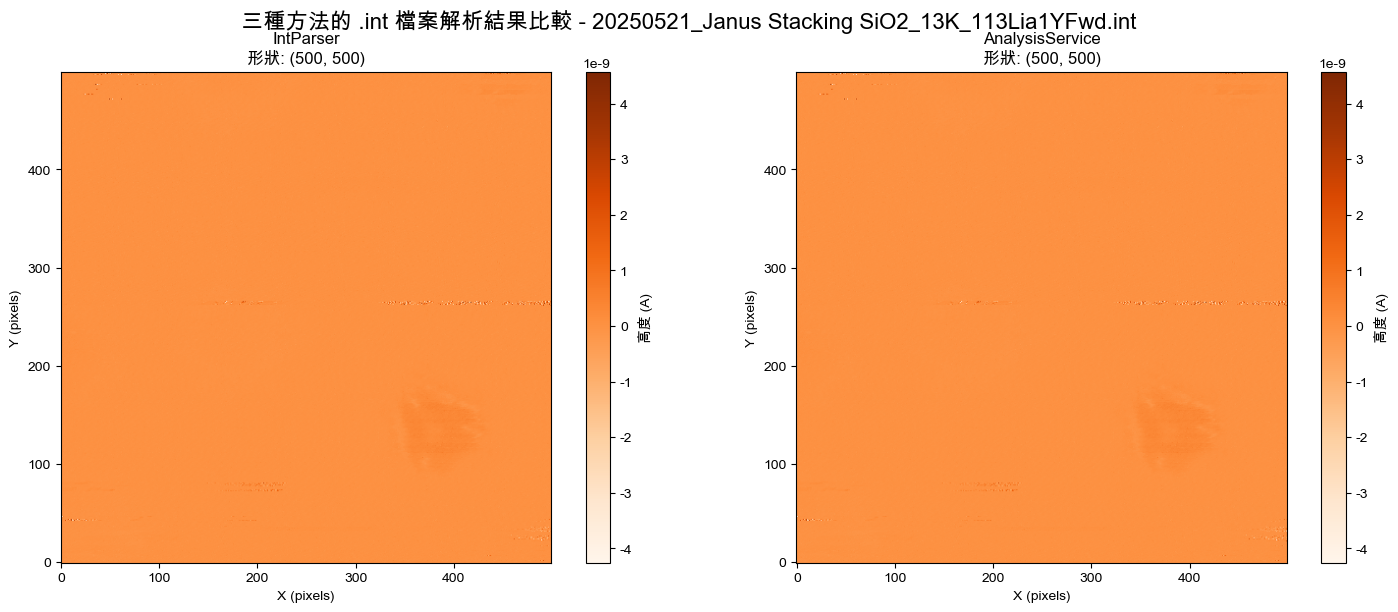


繪製差異圖:


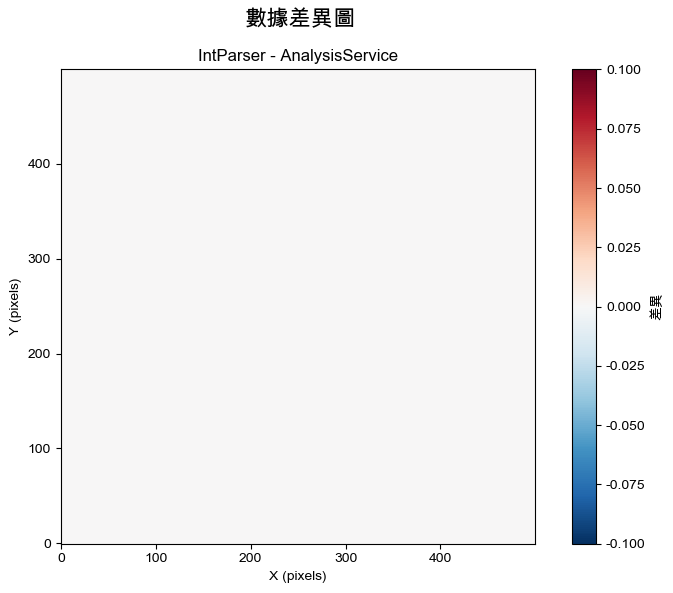

In [46]:
# 第七個 Cell - 視覺化比較結果
def visualize_comparison():
    """視覺化三種方法的結果"""
    print("=== 視覺化比較結果 ===")
    
    results = []
    if parser_result:
        results.append(parser_result)
    if service_result:
        results.append(service_result)
    if api_result:
        results.append(api_result)
    
    if not results:
        print("沒有結果可以視覺化")
        return
    
    n_results = len(results)
    
    # 創建子圖
    if n_results == 1:
        fig, axes = plt.subplots(1, 1, figsize=(8, 6))
        axes = [axes]
    elif n_results == 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        if n_results == 3:
            # 隱藏第四個子圖
            axes[1, 1].set_visible(False)
        axes = axes.flatten()
    
    fig.suptitle(f"三種方法的 .int 檔案解析結果比較 - {parser_result['filename'] if parser_result else 'Unknown'}", fontsize=16)
    
    # 找到全局的數據範圍用於統一色階
    all_data = [result['data'] for result in results]
    global_min = min(np.min(data) for data in all_data)
    global_max = max(np.max(data) for data in all_data)
    
    # 繪製每種方法的結果
    for i, result in enumerate(results):
        ax = axes[i]
        data = result['data']
        method = result['method']
        
        # 繪製圖像
        im = ax.imshow(data, cmap='Oranges', vmin=global_min, vmax=global_max, origin='lower')
        ax.set_title(f"{method}\n形狀: {data.shape}")
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')
        
        # 添加色標
        plt.colorbar(im, ax=ax, label=f"高度 ({result['phys_unit']})")
    
    plt.tight_layout()
    plt.show()
    
    # 如果有多個結果，繪製差異圖
    if len(results) >= 2:
        print("\n繪製差異圖:")
        
        n_comparisons = 0
        comparison_pairs = []
        
        for i in range(len(results)):
            for j in range(i+1, len(results)):
                if results[i]['data'].shape == results[j]['data'].shape:
                    comparison_pairs.append((i, j))
                    n_comparisons += 1
        
        if n_comparisons > 0:
            if n_comparisons == 1:
                fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))
                axes2 = [ax2]
            elif n_comparisons == 2:
                fig2, axes2 = plt.subplots(1, 2, figsize=(15, 6))
            else:
                fig2, axes2 = plt.subplots(2, 2, figsize=(15, 12))
                axes2 = axes2.flatten()
            
            fig2.suptitle("數據差異圖", fontsize=16)
            
            for idx, (i, j) in enumerate(comparison_pairs):
                ax = axes2[idx] if n_comparisons > 1 else axes2[0]
                
                data1 = results[i]['data']
                data2 = results[j]['data']
                method1 = results[i]['method']
                method2 = results[j]['method']
                
                diff = data1 - data2
                
                im = ax.imshow(diff, cmap='RdBu_r', origin='lower')
                ax.set_title(f"{method1} - {method2}")
                ax.set_xlabel('X (pixels)')
                ax.set_ylabel('Y (pixels)')
                
                plt.colorbar(im, ax=ax, label="差異")
            
            # 隱藏多餘的子圖
            if n_comparisons > 1:
                for idx in range(n_comparisons, len(axes2)):
                    axes2[idx].set_visible(False)
            
            plt.tight_layout()
            plt.show()

# 執行視覺化
visualize_comparison()

In [43]:
# 第八個 Cell - 總結報告
def generate_summary_report():
    """生成總結報告"""
    print("=== .int 檔案解析方法比較總結報告 ===")
    
    methods_tested = []
    if parser_result:
        methods_tested.append("IntParser (直接解析)")
    if service_result:
        methods_tested.append("AnalysisService (服務層)")
    if api_result:
        methods_tested.append("API MVP (API 層)")
    
    print(f"\n測試的方法: {', '.join(methods_tested)}")
    
    if parser_result:
        print(f"測試檔案: {parser_result['filename']}")
    
    print(f"\n=== 測試結果概要 ===")
    
    # 成功率統計
    total_methods = 3
    successful_methods = len(methods_tested)
    success_rate = (successful_methods / total_methods) * 100
    
    print(f"成功解析方法數: {successful_methods}/{total_methods} ({success_rate:.1f}%)")
    
    # 數據一致性檢查
    if len(methods_tested) >= 2:
        results = []
        if parser_result:
            results.append(parser_result)
        if service_result:
            results.append(service_result)
        if api_result:
            results.append(api_result)
        
        print(f"\n=== 數據一致性分析 ===")
        
        all_same_shape = True
        all_numerically_close = True
        
        for i in range(len(results)):
            for j in range(i+1, len(results)):
                data1 = results[i]['data']
                data2 = results[j]['data']
                method1 = results[i]['method']
                method2 = results[j]['method']
                
                if data1.shape != data2.shape:
                    all_same_shape = False
                    print(f"⚠️  {method1} 和 {method2} 的數據形狀不同")
                else:
                    if not np.allclose(data1, data2, rtol=1e-6, atol=1e-12):
                        all_numerically_close = False
                        max_diff = np.max(np.abs(data1 - data2))
                        print(f"⚠️  {method1} 和 {method2} 的數據存在差異 (最大差異: {max_diff:.6e})")
        
        if all_same_shape and all_numerically_close:
            print("✅ 所有方法產生的數據在數值精度內完全一致")
        elif all_same_shape:
            print("🔸 所有方法產生的數據形狀一致，但存在數值差異")
        else:
            print("❌ 不同方法產生的數據存在形狀或數值差異")
    
    print(f"\n=== 建議 ===")
    
    if successful_methods == total_methods:
        print("✅ 所有解析方法都成功運行")
        if 'all_numerically_close' in locals() and all_numerically_close:
            print("✅ 數據一致性良好，可以信任任何一種方法")
        else:
            print("⚠️  建議進一步調查數據差異的原因")
    else:
        failed_methods = []
        if not parser_result:
            failed_methods.append("IntParser")
        if not service_result:
            failed_methods.append("AnalysisService")
        if not api_result:
            failed_methods.append("API MVP")
        
        print(f"⚠️  以下方法需要檢查: {', '.join(failed_methods)}")
    
    print(f"\n=== 性能考量 ===")
    print("• IntParser: 最直接，適合批次處理")
    print("• AnalysisService: 功能豐富，包含統計和圖像生成")
    print("• API MVP: 完整的用戶界面支持，包含 Plotly 配置")

# 生成總結報告
generate_summary_report()

=== .int 檔案解析方法比較總結報告 ===

測試的方法: IntParser (直接解析), AnalysisService (服務層)
測試檔案: 20250521_Janus Stacking SiO2_13K_113Lia1YFwd.int

=== 測試結果概要 ===
成功解析方法數: 2/3 (66.7%)

=== 數據一致性分析 ===
✅ 所有方法產生的數據在數值精度內完全一致

=== 建議 ===
⚠️  以下方法需要檢查: API MVP

=== 性能考量 ===
• IntParser: 最直接，適合批次處理
• AnalysisService: 功能豐富，包含統計和圖像生成
• API MVP: 完整的用戶界面支持，包含 Plotly 配置
